# Power Outages
* **See the main project notebook for instructions to be sure you satisfy the rubric!**
* See Project 03 for information on the dataset.
* A few example prediction questions to pursue are listed below. However, don't limit yourself to them!
    * Predict the severity (number of customers, duration, or demand loss) of a major power outage.
    * Predict the cause of a major power outage.
    * Predict the number and/or severity of major power outages in the year 2020.
    * Predict the electricity consumption of an area.

Be careful to justify what information you would know at the "time of prediction" and train your model using only those features.

1. State the *prediction problem* you are attempting. State whether the problem is a classification or regression problem. Explain your choice of target variable and evaluation metric (objective).
1. A summary of the baseline model:
    - The number of features, including how many are quantitative, ordinal, and nominal.
    - The model performance (your evaluation metric) and whether you think this it's good or not (and why).
1. A summary of the final, improved model:
    - The features you added and *why* they are good for your data.
    - The model type you chose; the parameters that ended up performing best; the method of model selection used.
1. Evaluate your model for "fairness" on an interesting subset of the data using a permutation test. Justify the parity measure you are using.

# Summary of Findings


### Introduction
Following from project 03, in this Jupyter notebook, we focus our analysis on the dataset from [here](https://engineering.purdue.edu/LASCI/research-data/outages/outagerisks). This dataset serves as a rich repository of various information related to the major outage patterns, and characteristics of the states in the continental U.S., including their climate and topographical characteristics, electricity consumption patterns, population, and land-cover characteristics. In this project, we are going to come up with a prediction question based on this data, and answer it by using the method we learned during lecture.

### Prediction Problem
 - Specifically, the prediction question we want to answer is "Predict the cause of a major power outage". To be more specific, we choose 'severe weather' in column `CAUSE.CATEGORY` in the table and want to know what other factors will trigger a major power outage that is caused by severe weather.
 - This problem is a classification prblem and our choice of target variables are `MONTH`, `CLIMATE.REGION`, `ANOMALY.LEVEL`, `CLIMATE.CATEGORY`, `CUSTOMERS.AFFECTED`, `DEMAND.LOSS.MW`, `OUTAGE.DURATION`. We use these variables because they are related to the cause of the outage. 
 - We use accuracy as our evaluation metric in our model since we have a similar amount of positive and negative data.

### Baseline Model
 - In our baseline model, we included 7 features, which are `MONTH`, `CLIMATE.REGION`, `ANOMALY.LEVEL`, `CLIMATE.CATEGORY`, `CUSTOMERS.AFFECTED`, `DEMAND.LOSS.MW`, `OUTAGE.DURATION`. Among them, `ANOMALY.LEVEL`, `CUSTOMERS.AFFECTED`, `DEMAND.LOSS.MW`, `OUTAGE.DURATION` are quantitative, `CLIMATE.REGION`, `CLIMATE.CATEGORY` and `MONTH` are nominal. (We counted `MONTH` as norminal since there are different years, details are illustrated in the project)
 - The accuracy of our baseline model prediction is 0.841, which is not bad. I think it is pretty good since 84.1% of the predictions are accurate, which is a relatively high rate.

### Final Model
 - For our final model, we have added two features. The first one is to bining `DEMAND.LOSS.MW` and the second one is tha take the square root of `CUSTOMERS.AFFECTED`. We believe that binning the DEMAND.LOSS.MW can help our prediction because when people are reporting demand loss, they tend to only care about the magnitude, like whether the loss is in hundred, thousand or ten thousands. So, binning will make our data more meanningful. Taking square root of customers affected is also useful, since the customer affected data is heavly skewed to the right. Taking square root can correct this skewness. We have added these features and took a look at the accuracy, the accuracy has imporved.
 - We choose Decision Tree classifier as our model and we find that 4 is the best parameters for the depth of the decision tree. We use a for loop to perform the pipeline accuracy under different max_depth, and find the max accuracy.

### Fairness Evaluation
 - For our fairness evaluation, we choose the column `POPULATION` and want to conduct a test that if severe weather causing the outages is "fair" among the different populations in states. 
  - We will use recall as our parity measurement. Since it will represent the proportion of actual positives were correctly identified.
 - Our null hypothesis is: severe weather causing the outages is "fair" among the different populations in states. The recall value for two groups are the same.
 - Alternative hypothesis is: severe weather causing the outages is NOT "fair" among the different populations in states. The recall value for two groups are different.


# Code

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_format = 'retina'  # Higher resolution figures

In [2]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import Binarizer
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.preprocessing import Normalizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.impute import SimpleImputer
from sklearn import metrics

### Baseline Model

In the following code, we develop a baseline model with generic set of features.

In [46]:
# Read data
df = pd.read_excel("outage.xlsx")

# Do some basic cleaning as did in project03
df1 = df.iloc[4:, :]
column_names = df1.iloc[0].values[2:]
df2 = df1.iloc[2:, 2:]
df2.columns = column_names
df2.index = range(df2.shape[0])

In [47]:
# This is the data after basic cleaning
df2.head()

,YEAR,MONTH,U.S._STATE,POSTAL.CODE,NERC.REGION,CLIMATE.REGION,ANOMALY.LEVEL,CLIMATE.CATEGORY,OUTAGE.START.DATE,OUTAGE.START.TIME,...,POPPCT_URBAN,POPPCT_UC,POPDEN_URBAN,POPDEN_UC,POPDEN_RURAL,AREAPCT_URBAN,AREAPCT_UC,PCT_LAND,PCT_WATER_TOT,PCT_WATER_INLAND
0,2011,7,Minnesota,MN,MRO,East North Central,-0.3,normal,2011-07-01 00:00:00,17:00:00,...,73.27,15.28,2279,1700.5,18.2,2.14,0.6,91.5927,8.40733,5.47874
1,2014,5,Minnesota,MN,MRO,East North Central,-0.1,normal,2014-05-11 00:00:00,18:38:00,...,73.27,15.28,2279,1700.5,18.2,2.14,0.6,91.5927,8.40733,5.47874
2,2010,10,Minnesota,MN,MRO,East North Central,-1.5,cold,2010-10-26 00:00:00,20:00:00,...,73.27,15.28,2279,1700.5,18.2,2.14,0.6,91.5927,8.40733,5.47874
3,2012,6,Minnesota,MN,MRO,East North Central,-0.1,normal,2012-06-19 00:00:00,04:30:00,...,73.27,15.28,2279,1700.5,18.2,2.14,0.6,91.5927,8.40733,5.47874
4,2015,7,Minnesota,MN,MRO,East North Central,1.2,warm,2015-07-18 00:00:00,02:00:00,...,73.27,15.28,2279,1700.5,18.2,2.14,0.6,91.5927,8.40733,5.47874


In this project, we want to predict the cause of a major power outage based on the information in the table. Specifically, we choose 'severe weather' in column `CAUSE.CATEGORY` and want to know what other factors will trigger a major power outage that is caused by severe weather.

First, we select few useful variables in our table that may help our predictions.
- `MONTH` may be helpful, since severe weather may occur in some special months of a year.
- `CLIMATE.REGION` may be helpful, since severe weather may more likely to occur in certain region than others.
- `ANOMALY.LEVEL` and `CLIMATE.CATEGORY` may also be helpful since they are heavily related to climate, which may cause severe weather
- `CUSTOMERS.AFFECTED` may be helpful. Since severe weather can influence a large region, it may indicate more affected customers may indicate that the ouage is caused by severe weather 
- `OUTAGE.DURATION` and `DEMAND.LOSS.MW` may also helpful since outages caused by severe weather would have their specific duration and demand loss -- but we are not sure about this, so we will check whether they have relationship with outages that are caused by severe weather or not first.

After selecting the set of variables, we firstly do some EDA on `CAUSE.CATEGORY`, `OUTAGE.DURATION` and `DEMAND.LOSS.MW`

In [48]:
# copy the cleaned dataframe
df3 = df2.copy()

# rename the column 'CAUSE.CATEGORY' by whether it is equal to "severe weather"
df3["CAUSE.CATEGORY"] = (df3["CAUSE.CATEGORY"] == "severe weather")

# change the datatype of columns "DEMAND.LOSS.MW" and "OUTAGE.DURATION"
df3["DEMAND.LOSS.MW"] = df3["DEMAND.LOSS.MW"].astype(np.float64)
df3["OUTAGE.DURATION"] = df3["OUTAGE.DURATION"].astype(np.float64)

# df3 is the new dataframe with columns 'CAUSE.CATEGORY', "DEMAND.LOSS.MW" and "OUTAGE.DURATION" adjusted
df3.head()

,YEAR,MONTH,U.S._STATE,POSTAL.CODE,NERC.REGION,CLIMATE.REGION,ANOMALY.LEVEL,CLIMATE.CATEGORY,OUTAGE.START.DATE,OUTAGE.START.TIME,...,POPPCT_URBAN,POPPCT_UC,POPDEN_URBAN,POPDEN_UC,POPDEN_RURAL,AREAPCT_URBAN,AREAPCT_UC,PCT_LAND,PCT_WATER_TOT,PCT_WATER_INLAND
0,2011,7,Minnesota,MN,MRO,East North Central,-0.3,normal,2011-07-01 00:00:00,17:00:00,...,73.27,15.28,2279,1700.5,18.2,2.14,0.6,91.5927,8.40733,5.47874
1,2014,5,Minnesota,MN,MRO,East North Central,-0.1,normal,2014-05-11 00:00:00,18:38:00,...,73.27,15.28,2279,1700.5,18.2,2.14,0.6,91.5927,8.40733,5.47874
2,2010,10,Minnesota,MN,MRO,East North Central,-1.5,cold,2010-10-26 00:00:00,20:00:00,...,73.27,15.28,2279,1700.5,18.2,2.14,0.6,91.5927,8.40733,5.47874
3,2012,6,Minnesota,MN,MRO,East North Central,-0.1,normal,2012-06-19 00:00:00,04:30:00,...,73.27,15.28,2279,1700.5,18.2,2.14,0.6,91.5927,8.40733,5.47874
4,2015,7,Minnesota,MN,MRO,East North Central,1.2,warm,2015-07-18 00:00:00,02:00:00,...,73.27,15.28,2279,1700.5,18.2,2.14,0.6,91.5927,8.40733,5.47874


We check if `DEMAND.LOSS.MW` and `OUTAGE.DURATION` really have effects among the outages that are caused by severe weather and outages that are not.

In [49]:
# check for "DEMAND.LOSS.MW"
df3.groupby("CAUSE.CATEGORY")["DEMAND.LOSS.MW"].mean()

CAUSE.CATEGORY
False    462.036697
True     618.661578
Name: DEMAND.LOSS.MW, dtype: float64

In [50]:
# check for "OUTAGE.DURATION"
df3.groupby("CAUSE.CATEGORY")["OUTAGE.DURATION"].mean()

CAUSE.CATEGORY
False    1346.178962
True     3883.985215
Name: OUTAGE.DURATION, dtype: float64

We can see that there is a difference in variables `DEMAND.LOSS.MW` and `OUTAGE.DURATION` between the outages that are caused by severe weather and the outages that are not. Therefore, it turns out that these two variables is worth including in our model.

- As we verified `DEMAND.LOSS.MW` and `OUTAGE.DURATION` can be included in our model, we will use `MONTH`, `CLIMATE.REGION`, `ANOMALY.LEVEL`, `CLIMATE.CATEGORY`, `CUSTOMERS.AFFECTED`, `DEMAND.LOSS.MW`, `OUTAGE.DURATION` for our prediction model. 
- There are total 7 features. `ANOMALY.LEVEL`, `CUSTOMERS.AFFECTED`, `DEMAND.LOSS.MW`, `OUTAGE.DURATION` are quantitative, `CLIMATE.REGION`, `CLIMATE.CATEGORY` and `MONTH` are nominal. 
    - Note that `MONTH` here is a nominal variable since there are different years in this data set. We cannnot say that 2007-01 is preceding 2006-03, although 3 is larger than 1. So, we treat month as a nomial variable.

In [60]:
# For simplicity, we extract the columns that we mentioned above into a new dataframe
df4 = df2[["MONTH", "CLIMATE.REGION", "CLIMATE.CATEGORY", "ANOMALY.LEVEL", "CUSTOMERS.AFFECTED", "DEMAND.LOSS.MW", "OUTAGE.DURATION", "CAUSE.CATEGORY"]]

# df4 is the new simplified dataframe
df4.head()

,MONTH,CLIMATE.REGION,CLIMATE.CATEGORY,ANOMALY.LEVEL,CUSTOMERS.AFFECTED,DEMAND.LOSS.MW,OUTAGE.DURATION,CAUSE.CATEGORY
0,7,East North Central,normal,-0.3,70000,NaN,3060,severe weather
1,5,East North Central,normal,-0.1,NaN,NaN,1,intentional attack
2,10,East North Central,cold,-1.5,70000,NaN,3000,severe weather
3,6,East North Central,normal,-0.1,68200,NaN,2550,severe weather
4,7,East North Central,warm,1.2,250000,250,1740,severe weather


Next, we do type conversion on certain variables and change the `CAUSE.CATEGORY` to binary variable

In [61]:
# type conversion on "DEMAND.LOSS.MW", "OUTAGE.DURATION", "CUSTOMERS.AFFECTED" and "ANOMALY.LEVEL"
df4["DEMAND.LOSS.MW"] = df4["DEMAND.LOSS.MW"].astype(np.float64)
df4["OUTAGE.DURATION"] = df4["OUTAGE.DURATION"].astype(np.float64)
df4["CUSTOMERS.AFFECTED"] = df4["CUSTOMERS.AFFECTED"].astype(np.float64)
df4["ANOMALY.LEVEL"] = df4["ANOMALY.LEVEL"].astype(np.float64)

# change the "CAUSE.CATEGORY" to binary variable
df4["CAUSE.CATEGORY"] = (df4["CAUSE.CATEGORY"] == "severe weather").replace({True:1, False:0})

# This is the resulted dataframe after type conversion and change on "CAUSE.CATEGORY"
df4.head()

,MONTH,CLIMATE.REGION,CLIMATE.CATEGORY,ANOMALY.LEVEL,CUSTOMERS.AFFECTED,DEMAND.LOSS.MW,OUTAGE.DURATION,CAUSE.CATEGORY
0,7,East North Central,normal,-0.3,70000.0,NaN,3060.0,1
1,5,East North Central,normal,-0.1,NaN,NaN,1.0,0
2,10,East North Central,cold,-1.5,70000.0,NaN,3000.0,1
3,6,East North Central,normal,-0.1,68200.0,NaN,2550.0,1
4,7,East North Central,warm,1.2,250000.0,250.0,1740.0,1


In [62]:
# Compute the proportion of group that are caused by severe weather
np.mean(df4["CAUSE.CATEGORY"])

0.4973924380704042

The result is approximately 0.497. Since we have positive and negative group almost the same proportion, we can use accuracy as our objective

In [63]:
# Check if there are null values in "CAUSE.CATEGORY"
pd.isnull(df4).mean()

MONTH                 0.005867
CLIMATE.REGION        0.003911
CLIMATE.CATEGORY      0.005867
ANOMALY.LEVEL         0.005867
CUSTOMERS.AFFECTED    0.288787
DEMAND.LOSS.MW        0.459583
OUTAGE.DURATION       0.037810
CAUSE.CATEGORY        0.000000
dtype: float64

There is no null values in column `CAUSE.CATEGORY `. Then, we will do train test split.

In [64]:
# Conduct the train test split on our dataframe
X = df4.drop("CAUSE.CATEGORY", axis=1)
y = df4["CAUSE.CATEGORY"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

Now, let's build the pipeline.
We will use SimpleImputer to deal with nan value. We impute categorical variable by most frequent value and quantitative variable by mean. It's not strange to fill categorical value with the most frequent value, since the missingness proportion is very small. It is also reasonable to fill quantitative variable with mean, since there is no clear missing reason or pattern.

In [65]:
# Build a pipeline

# Categorical features
# do onehot encoding for categorical features
cat_feat = ["CLIMATE.REGION", "CLIMATE.CATEGORY", "MONTH"]
cat_filler = SimpleImputer(strategy = "most_frequent")
cat_transformer = Pipeline(steps=[
    ("fill_onehot_nan", cat_filler),
    ("one_hot", OneHotEncoder(handle_unknown = "ignore"))
])

# Numerical features
num_feat = ["ANOMALY.LEVEL", "CUSTOMERS.AFFECTED", "DEMAND.LOSS.MW", "OUTAGE.DURATION"]
num_filler = SimpleImputer(strategy = "mean")
num_transformer = Pipeline(steps=[
    ("fill_num_nan", num_filler)
])

col_trans1 = ColumnTransformer(
    transformers=[
        ("cat", cat_transformer, cat_feat),
        ("num", num_transformer, num_feat)
    ])

# pl is the resulted pipeline
pl = Pipeline([("col_transformer", col_trans1), ("classifier", DecisionTreeClassifier())])

In [66]:
# fit the pipeline with train data
pl.fit(X_train, y_train)

Pipeline(steps=[('col_transformer',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('fill_onehot_nan',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('one_hot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['CLIMATE.REGION',
                                                   'CLIMATE.CATEGORY',
                                                   'MONTH']),
                                                 ('num',
                                                  Pipeline(steps=[('fill_num_nan',
                                                                   SimpleImputer())]),
                                                  ['ANOMALY.LEVEL',
                           

In [67]:
# using the model we get, obtain the prediction of the test data
prediction = pl.predict(X_test)

In [68]:
# find the accuracy score of this model
metrics.accuracy_score(y_test, prediction)

0.8411458333333334

From the result, we get an accuracy of 84.1%, which is not bad, but we still want to increase the accuracy by conducting some feature engerineering.

We guess that bining `DEMAND.LOSS.MW` level might help to increase our test accuracy. Since we use mean imputation to impute the missing value, binning can help us differentiate these value and increase our prediction accuracy.

In [69]:
# generate two separate graphs when "CAUSE.CATEGORY" equal to 1 and 0, separately
df41 = df4[df4["CAUSE.CATEGORY"] == 1]
df40 = df4[df4["CAUSE.CATEGORY"] == 0]

<AxesSubplot:ylabel='Frequency'>

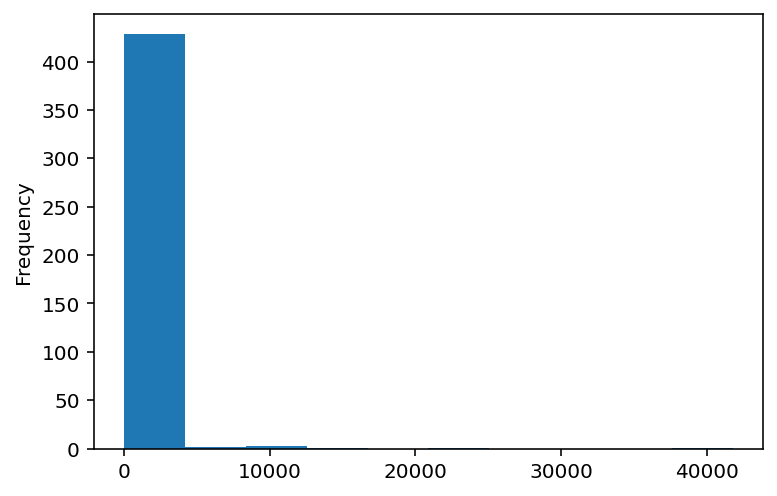

In [70]:
# draw a histogram of the frequency of value of "DEMAND.LOSS.MW" under condition that "CAUSE.CATEGORY" equal to 0
df40["DEMAND.LOSS.MW"].plot(kind = "hist")

<AxesSubplot:ylabel='Frequency'>

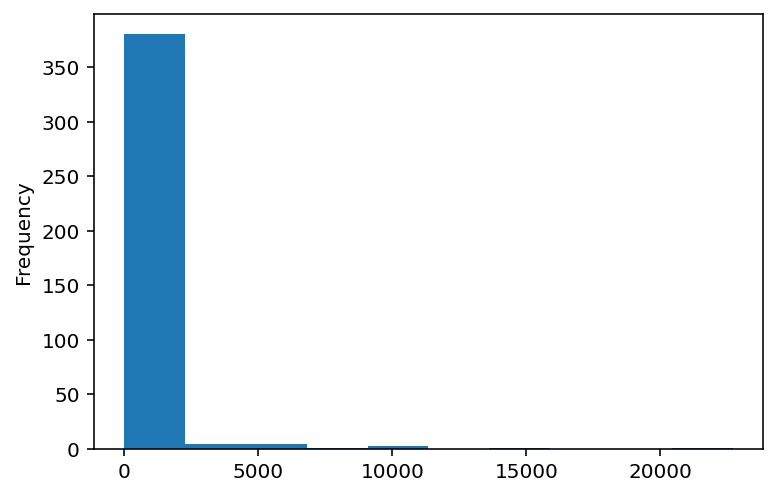

In [71]:
# draw a histogram of the frequency of value of "DEMAND.LOSS.MW" under condition that "CAUSE.CATEGORY" equal to 1
df41["DEMAND.LOSS.MW"].plot(kind = "hist")

In [72]:
# Build another pipeline with bining "DEMAND.LOSS.MW", and other variables remain the same
# Categorical features
cat_feat = ["CLIMATE.REGION", "CLIMATE.CATEGORY", "MONTH"]
cat_filler = SimpleImputer(strategy = "most_frequent")
cat_transformer = Pipeline(steps=[
    ("fill_onehot_nan", cat_filler),
    ("one_hot", OneHotEncoder(handle_unknown = "ignore"))
])

# Numerical features
num_feat = ["CUSTOMERS.AFFECTED", "OUTAGE.DURATION", "ANOMALY.LEVEL"]
num_filler = SimpleImputer(strategy = "mean")
num_transformer = Pipeline(steps=[
    ("fill_num_nan", num_filler)
])

# Added -- bining "DEMAND.LOSS.MW"
bins_feat = ["DEMAND.LOSS.MW"]
bins_transformer = Pipeline(steps=[
    ("fill_num_nan", num_filler), 
    ("bin", KBinsDiscretizer(n_bins=15, encode='onehot', strategy='uniform')),
])

col_trans2 = ColumnTransformer(
    transformers=[
        ("cat", cat_transformer, cat_feat),
        ("num", num_transformer, num_feat),
        ("bins", bins_transformer, bins_feat)
    ])

# This is the resulted pipeline
pl1 = Pipeline([("col_transformer", col_trans2), ("classifier", DecisionTreeClassifier())])

In [73]:
# fit the pipeline with train data
pl1.fit(X_train, y_train)

Pipeline(steps=[('col_transformer',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('fill_onehot_nan',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('one_hot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['CLIMATE.REGION',
                                                   'CLIMATE.CATEGORY',
                                                   'MONTH']),
                                                 ('num',
                                                  Pipeline(steps=[('fill_num_nan',
                                                                   SimpleImputer())]),
                                                  ['CUSTOMERS.AFFECTED',
                      

In [74]:
# using the model we get, obtain the prediction of the test data
prediction1 = pl1.predict(X_test)

In [75]:
# find the accuracy score of this model
metrics.accuracy_score(y_test, prediction1)

0.8515625

Our accuracy increases from 84.1% to 85.2%. That is pretty nice.

We also guess that square root transform of `CUSTOMERS.AFFECTED` will help our prediction to be more accurate, since the distribution of `CUSTOMER.AFFECTED` is greatly skewed to the right.

<AxesSubplot:ylabel='Frequency'>

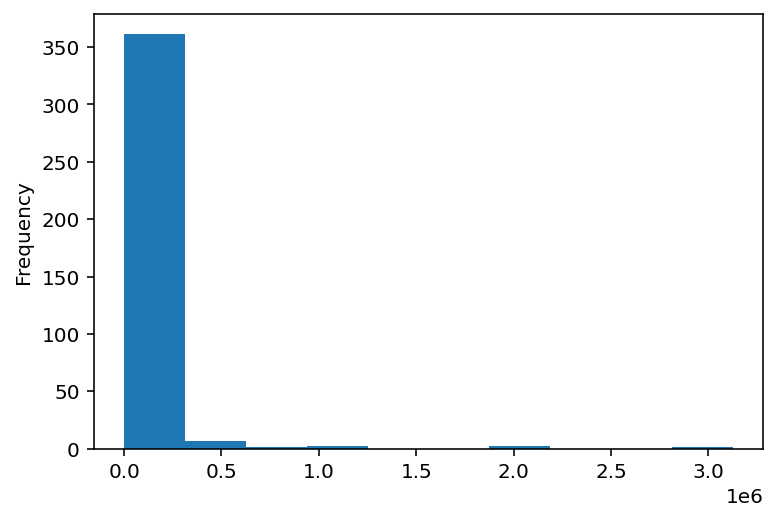

In [76]:
# draw a histogram of the frequency of value of "CUSTOMERS.AFFECTED" under condition that "CAUSE.CATEGORY" equal to 0
df40["CUSTOMERS.AFFECTED"].plot(kind = "hist")

<AxesSubplot:ylabel='Frequency'>

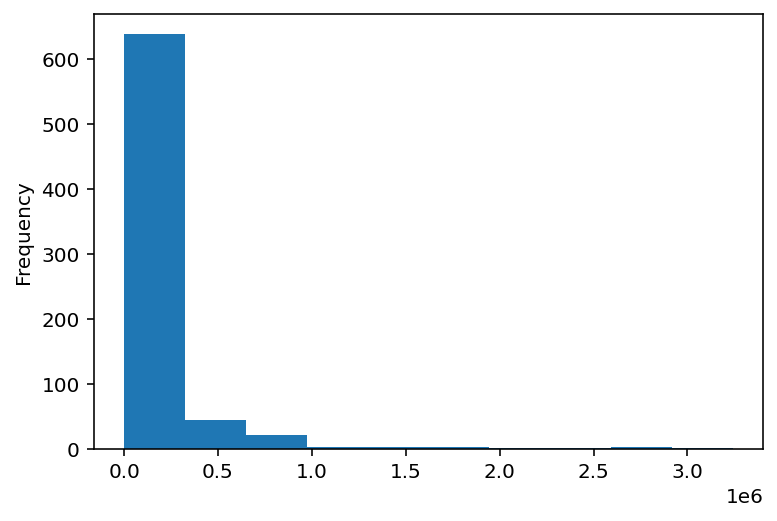

In [77]:
# draw a histogram of the frequency of value of "CUSTOMERS.AFFECTED" under condition that "CAUSE.CATEGORY" equal to 0
df41["CUSTOMERS.AFFECTED"].plot(kind = "hist")

From the two graphs, we can see that the graph of `CUSTOMERS.AFFECTED` is skewed to the right. So we use the square root transform of `CUSTOMERS.AFFECTED` in our new model.

In [82]:
# Build another pipeline with bining "DEMAND.LOSS.MW" and transforming "CUSTOMERS.AFFECTED" to square root,
# and other variables remain the same

# Categorical features
cat_feat = ["CLIMATE.REGION", "CLIMATE.CATEGORY", "MONTH"]
cat_filler = SimpleImputer(strategy = "most_frequent")
cat_transformer = Pipeline(steps=[
    ("fill_onehot_nan", cat_filler),
    ("one_hot", OneHotEncoder(handle_unknown = "ignore"))
])

# Numerical features
num_feat = ["ANOMALY.LEVEL", "OUTAGE.DURATION"]
num_filler = SimpleImputer(strategy = "mean")
num_transformer = Pipeline(steps=[
    ("fill_num_nan", num_filler)
])

# Bining "DEMAND.LOSS.MW"
bins_feat = ["DEMAND.LOSS.MW"]
bins_transformer = Pipeline(steps=[
    ("fill_num_nan", num_filler), 
    ("bin", KBinsDiscretizer(n_bins=15, encode='onehot', strategy='uniform')),
])

# Added -- square root of "CUSTOMERS.AFFECTED"
cus_feat = ["CUSTOMERS.AFFECTED"]
cus_transformer = Pipeline(steps=[
    ("fill_num_nan", num_filler), 
    ("log", FunctionTransformer(lambda x: x**0.5, validate = False))
])

col_trans3 = ColumnTransformer(
    transformers=[
        ("cus", cus_transformer, cus_feat),
        ("cat", cat_transformer, cat_feat),
        ("num", num_transformer, num_feat),
        ("bins", bins_transformer, bins_feat)
    ])

# This is the resulted pipeline
pl2 = Pipeline([("col_transformer", col_trans3), ("classifier", DecisionTreeClassifier())])

In [83]:
# fit the pipeline with train data
pl2.fit(X_train, y_train)

Pipeline(steps=[('col_transformer',
                 ColumnTransformer(transformers=[('cus',
                                                  Pipeline(steps=[('fill_num_nan',
                                                                   SimpleImputer()),
                                                                  ('log',
                                                                   FunctionTransformer(func=<function <lambda> at 0x7f87b2f57280>))]),
                                                  ['CUSTOMERS.AFFECTED']),
                                                 ('cat',
                                                  Pipeline(steps=[('fill_onehot_nan',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('one_hot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
               

In [84]:
# using the model we get, obtain the prediction of the test data
prediction2 = pl2.predict(X_test)

In [85]:
# find the accuracy score of this model
metrics.accuracy_score(y_test, prediction2)

0.8723958333333334

Our accuracy increases from 85.2% to 87.2%. That is pretty nice.

Next, we look on our decision tree to get the best parameter of the depth of tree using a for loop to generate accuracy of the model on different depth.

In [112]:
accu = []
indices = []
for i in range(1, 21):
    # A new pipeline that used the improved model but using different max_depth
    pl3 = Pipeline([("col_transformer", col_trans3), ("classifier", DecisionTreeClassifier(max_depth=i))])
    
    # this is the same process as we do the pipeline before
    pl3.fit(X_train, y_train)
    prediction_p = pl3.predict(X_test)
    accuracy = metrics.accuracy_score(y_test, prediction_p)
    accu.append(accuracy)
    indices.append(i)

# combine the accuracy results and the value of max_depth
df_para = pd.DataFrame({"indices":indices, "accuracy":accu}).set_index("indices")

In [113]:
# resulted dataframe
df_para

,accuracy
indices,
1,0.770833
2,0.796875
3,0.825521
4,0.903646
5,0.893229
6,0.885417
7,0.877604
8,0.877604
9,0.867188


In [120]:
# find the depth of maximum accuracy in the dataframe
df_para['accuracy'].idxmax()

4

Therefore, we conclude that the best parameter is 4 in our improved model, and the max accuracy is 0.903646

### Final Model

Therefore, we conclude that our final model is the model that invovles 7 features, which are `MONTH`, `CLIMATE.REGION`, `ANOMALY.LEVEL`, `CLIMATE.CATEGORY`, square root of
`CUSTOMERS.AFFECTED`, bining `DEMAND.LOSS.MW`, `OUTAGE.DURATION` for our prediction model. 

**Remark**:
One thing that we want to remark here is that actually we have tried a lot of method of feature engerineering and none of them could significantly improve our model accuracy. The result we generated above could only imporve a little on accuracy.

### Fairness Evaluation

For our fairness evaluation, we choose the column `POPULATION` and want to conduct a test that if severe weather causing the outages is "fair" among the different populations in states. We will use recall as our parity measurement.

In [428]:
# display the original dataframe
df2.head()

,YEAR,MONTH,U.S._STATE,POSTAL.CODE,NERC.REGION,CLIMATE.REGION,ANOMALY.LEVEL,CLIMATE.CATEGORY,OUTAGE.START.DATE,OUTAGE.START.TIME,...,POPPCT_URBAN,POPPCT_UC,POPDEN_URBAN,POPDEN_UC,POPDEN_RURAL,AREAPCT_URBAN,AREAPCT_UC,PCT_LAND,PCT_WATER_TOT,PCT_WATER_INLAND
0,2011,7,Minnesota,MN,MRO,East North Central,-0.3,normal,2011-07-01 00:00:00,17:00:00,...,73.27,15.28,2279,1700.5,18.2,2.14,0.6,91.5927,8.40733,5.47874
1,2014,5,Minnesota,MN,MRO,East North Central,-0.1,normal,2014-05-11 00:00:00,18:38:00,...,73.27,15.28,2279,1700.5,18.2,2.14,0.6,91.5927,8.40733,5.47874
2,2010,10,Minnesota,MN,MRO,East North Central,-1.5,cold,2010-10-26 00:00:00,20:00:00,...,73.27,15.28,2279,1700.5,18.2,2.14,0.6,91.5927,8.40733,5.47874
3,2012,6,Minnesota,MN,MRO,East North Central,-0.1,normal,2012-06-19 00:00:00,04:30:00,...,73.27,15.28,2279,1700.5,18.2,2.14,0.6,91.5927,8.40733,5.47874
4,2015,7,Minnesota,MN,MRO,East North Central,1.2,warm,2015-07-18 00:00:00,02:00:00,...,73.27,15.28,2279,1700.5,18.2,2.14,0.6,91.5927,8.40733,5.47874


Firstly, we need to develop a threshold for the state having large and small population.

In [429]:
# Compute the median of population in the data
df2[['POPULATION']].median()

POPULATION    8769252.0
dtype: float64

The median of the population in this dataset is 8,769,252. Therefore, we set the state which has population lower than 8,000,000 to be 'small population state', and the state which has population larger than 8,000,000 to be 'large population state'

In [455]:
# Create a new dataframe df5 using the test data
df5=X_test

# Add a column that is equal to the actual value of cause in test data
df5['CAUSE.CATEGORY']=y_test

# Set the population to be "SMALL" and "LARGE" based on the population size
df5['statePopulation']=(df2.POPULATION <= 8000000).replace({True:'SMALL', False:'LARGE'})

# Add the prediction values
preds = pl2.predict(X_test)
df5['prediction']=preds

# df5 is the new dataframe that we are going to use
df5.head()

,MONTH,CLIMATE.REGION,CLIMATE.CATEGORY,ANOMALY.LEVEL,CUSTOMERS.AFFECTED,DEMAND.LOSS.MW,OUTAGE.DURATION,CAUSE.CATEGORY,statePopulation,prediction
463,8,Northwest,cold,-0.6,NaN,NaN,369.0,0,SMALL,0
237,4,South,normal,-0.2,51404.0,108.0,95.0,0,LARGE,0
87,11,East North Central,warm,2.2,60000.0,NaN,1710.0,1,LARGE,1
1064,9,Southeast,warm,0.7,285300.0,1250.0,2040.0,1,LARGE,1
426,3,Northwest,warm,1.6,0.0,0.0,1919.0,0,SMALL,0


Compute the recall using metrics_recall and find the observed predicting recalls among two groups.

In [456]:
(
    df5
    .groupby('statePopulation')
    .apply(lambda x: metrics.recall_score(x['CAUSE.CATEGORY'], x['prediction']))
    .rename('recall')
    .to_frame()
)

,recall
statePopulation,
LARGE,0.884615
SMALL,0.852941


Next, we perform the permutation test.

In [457]:
# This is the observed difference of recalls among different population groups.
obs = df5.groupby('statePopulation').apply(lambda x: metrics.recall_score(x['CAUSE.CATEGORY'], x['prediction'])).diff().iloc[-1]

# We perform permutation on the dataframe df5
metrs = []
for _ in range(100):
    s = (
        df5[['statePopulation', 'prediction', 'CAUSE.CATEGORY']]
        .assign(statePopulation=df5.statePopulation.sample(frac=1.0, replace=False).reset_index(drop=True))
        .groupby('statePopulation')
        .apply(lambda x: metrics.recall_score(x['CAUSE.CATEGORY'], x['prediction']))
        .diff()
        .iloc[-1]
    )
    
    metrs.append(s)



0.24


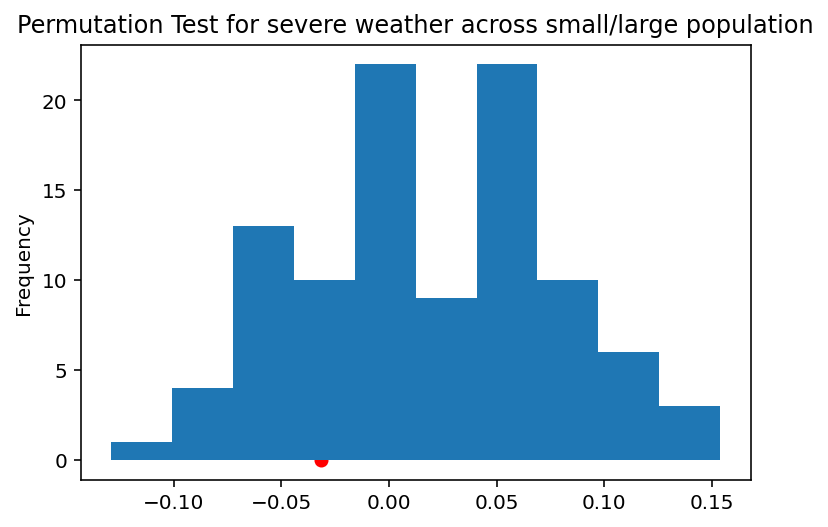

In [469]:
print(pd.Series(metrs <= obs).mean())
pd.Series(metrs).plot(kind='hist', title='Permutation Test for severe weather across small/large population')
plt.scatter(obs, -0.01, c='r');

Remark: The red point should be at height 0. However, since the graph covers the point and we cannot see, I adjust its height to a little bit negative.

The resulted p-value is 0.24, under a significance level of 0.01, we fail to reject the claim that severe weather causing the outages is "fair" among the different populations in states.